Using device: cuda
[54 59 32 ... 54 41 37]
tensor([[0.3694, 0.3694, 0.3694,  ..., 0.3694, 0.3694, 0.3694],
        [0.2358, 0.2358, 0.2358,  ..., 0.2358, 0.2358, 0.2358],
        [0.2799, 0.2799, 0.2799,  ..., 0.2799, 0.2799, 0.2799],
        ...,
        [0.2074, 0.2074, 0.2074,  ..., 0.2074, 0.2074, 0.2074],
        [0.3310, 0.3310, 0.3310,  ..., 0.3310, 0.3310, 0.3310],
        [0.1819, 0.1819, 0.1819,  ..., 0.1819, 0.1819, 0.1819]],
       device='cuda:0')
[1264 1729 1900 1963 1986 1995 1998 1999 1999 1999 1999 1999 1999 1999
 1999 1999 1999 1999 1999 1999 1999 1999 1999 1999 1999 1999 1999 1999
 1999 1999 1999 1999 1999 1999 1999 1999 1999 2000 2000 2000]
1


100%|██████████| 1000/1000 [00:02<00:00, 480.21it/s]


KS Test for Poisson: (0.161, 0.0)


100%|██████████| 1000/1000 [00:13<00:00, 72.76it/s]


KS Test for NB: (0.03543705703678701, 0.0)


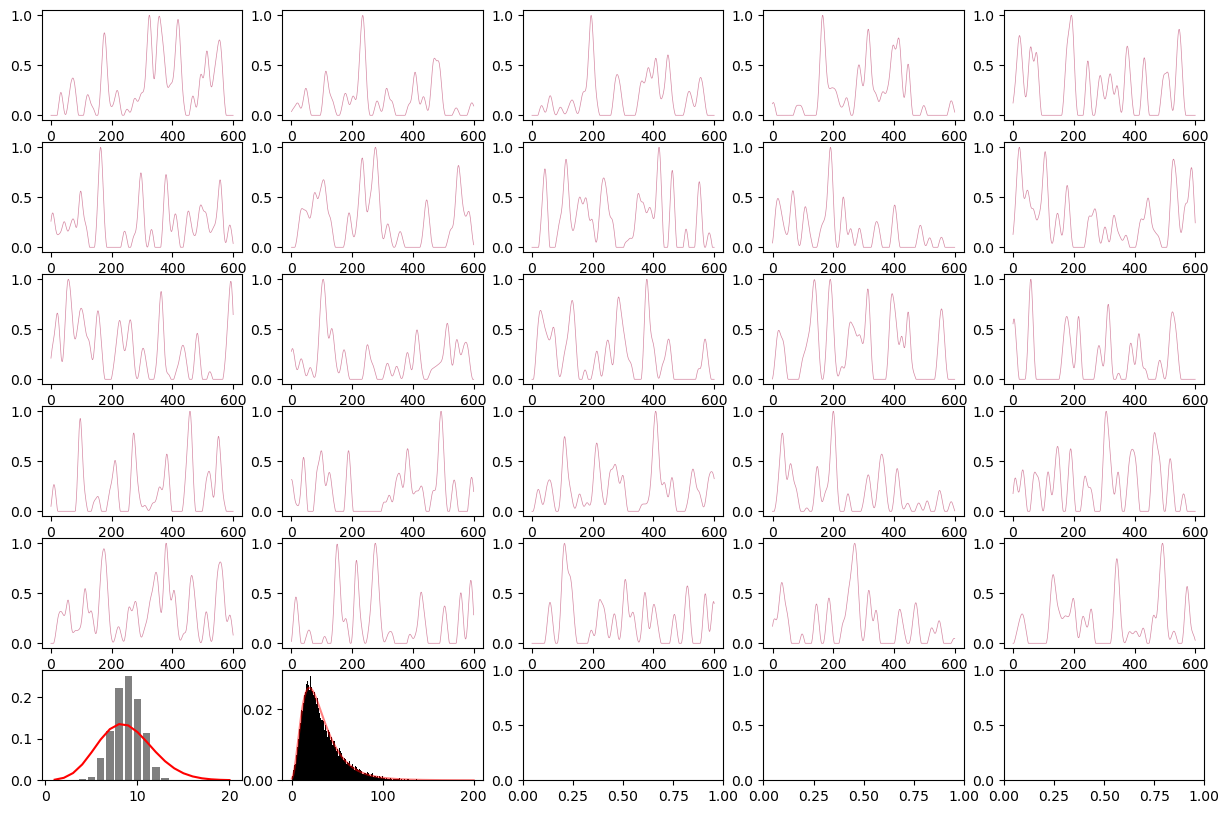

2


100%|██████████| 1000/1000 [00:02<00:00, 463.70it/s]


KS Test for Poisson: (0.1765, 0.0)


 44%|████▎     | 435/1000 [00:07<00:14, 39.44it/s]

In [1]:
import torch
import numpy as np
from model.neuron import PlaceCells, PlateuSignal
from tqdm import tqdm
from model.hebbian import update_state, hebbian_learning, anti_hebbian_learning
from model.utils import get_place_fields, get_field_num, get_field_size
from model.utils import fit_field_size, fit_field_number
from model.utils import poisson_kstest, nbinom_kstest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, lognorm, gamma

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
torch.set_default_device(device)

N_CA3 = 2000
N_CA1 = 2000
N_PLATEU = 10000

# Simulation parameters
N_LAP = 100  # Define the total number of laps
N_FRAME = 500 # Define the total frame number

eta_e = 0.02 # learning rate of hebbian learning
# Assume the learning rate is a linear function of neuronal propensity, which follows gamma distribution
# eta_e = gamma.rvs(11, loc=0, scale=0.002, size = N_CA1)
# eta_e = torch.from_numpy(np.repeat(np.reshape(eta_e, [N_CA1, 1]), N_CA3, axis=1)).float().to(device)
eta_i = 0.0008 # learning rate of anti-hebbian learning

# N_CA3_TO_CA1 = 20 # Define the current active synapse number from CA3 to CA1
N_CA3_TO_CA1 = (gamma.rvs(10, scale = 3, size = N_CA3)//1).astype(np.int64)
# N_CA3_TO_CA1 = np.repeat(100, N_CA3)
# N_CA1_RECEIVE_CA3 = (gamma.rvs(20, scale=1, size=N_CA1)//1).astype(int)
# print(N_CA1_RECEIVE_CA3)
print(N_CA3_TO_CA1)

thre = torch.from_numpy(np.repeat(np.reshape(gamma.rvs(10, scale=0.03, size = N_CA1), [N_CA1, 1]), N_FRAME, axis=1)).float().to(device)
print(thre)
# Initial neuron states
PCs = PlaceCells(N_CA3, N_FRAME)
t = PCs.t
PCs.lapwise_simulate(tau = 1, n_lap=N_LAP)

Y = torch.zeros((N_CA1, N_FRAME))

M = torch.zeros((N_CA1, N_CA1))
W = torch.zeros((N_CA1, N_CA3))

for i in range(N_CA3):
    W[torch.randint(0, N_CA1, size=(N_CA3_TO_CA1[i], 1)), i] = 1
    #W[i, torch.randint(0, N_CA3, size=(N_CA1_RECEIVE_CA3[i], 1))] = 1

colors = sns.color_palette("Spectral", N_LAP)
x_size = np.linspace(0,200, 20001)
x_num = np.arange(1, 21)
#fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 10))
mean_size = np.zeros(N_LAP)
for l in range(N_LAP):
    print(l+1)
    X = torch.from_numpy(PCs.get_map(l)).float().to(device)
    # Update neuron states
    Y = update_state(X, W, Y, M, thre=thre)
    
    # Apply learning rules
    W = hebbian_learning(W, X, Y, eta=eta_e)
    M = anti_hebbian_learning(M, Y, eta=eta_i)
    
    # Optionally: Record states and weights for analysis and visualization
    # ...
    
    y = Y.cpu().numpy()
    """
    fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 10))
    for i in range(5):
        for j in range(5):
            axes[i, j].plot(t, y[i*5+j, :], linewidth = 0.5, color=colors[l], alpha=0.5)
    """

    place_field = get_place_fields(y, parameter=0.1)
    #field_num = get_field_num(place_field)
    field_size = get_field_size(place_field)
    #a, b, c = fit_field_size(field_size)
    """
    y_size = lognorm.pdf(x_size, a, b, c)
    lam = fit_field_number(field_num)
    y_num = poisson.pmf(x_num, lam)
    
    #print("KS Test for Poisson:", poisson_kstest(field_num, monte_carlo_times=1000))
    #print("KS Test for NB:", nbinom_kstest(field_size, monte_carlo_times=1000))
    axes[5, 0].plot(x_num, y_num, color='red')
    axes[5, 1].plot(x_size, y_size, color='red', alpha=0.5)
    
    axes[5, 0].hist(field_num, bins=20, color = 'gray', rwidth = 0.8, range=(0.5, 20.5), density=True)
    axes[5, 1].hist(field_size, bins=200, color='black', range=(-0.5, 199.5), density=True)
    """
    mean_size[l] = np.mean(field_size)
    #plt.show()

plt.plot(tt, mean_size)
# Visualization and analysis
# ...
